# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [42]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
import tensorflow as tf
import json

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# Import statements used for building the classifier of the model
from collections import OrderedDict

# Import workspace_utils
import workspace_utils
from workspace_utils import active_session

# Imports for image processing
from torch.autograd import Variable
from PIL import Image

# General imports
import os
import math


In [43]:
# Define general variables

# Model architecture
#arch = 'vgg16'
arch = 'densenet201'

# Model layer sizes
## For VGG16
#input_size = 25088
#hidden_sizes = [4096, 1024]
#output_size = 120

## For DenseNet201
input_size = 1920
hidden_sizes = [960]
output_size = 102

# Model dropout
drop_p = 0.35

# Optimizer learning rate
learning_rate = 0.001

# Model training
epochs = 3
print_every = 20

# Path to the checkpoint file
filepath = 'project_checkpoint.pth'

# Example image for testing image processing
sample_image_file = 'test/11/image_03176.jpg'

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [44]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

sample_image_path = os.path.join(data_dir, sample_image_file)

In [45]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train' : transforms.Compose([transforms.RandomRotation(330),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])]),
    'valid_test' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    'train' : datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid' : datasets.ImageFolder(valid_dir, transform=data_transforms['valid_test']),
    'test' : datasets.ImageFolder(test_dir, transform=data_transforms['valid_test'])
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
data_loaders = {
    'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'valid' : torch.utils.data.DataLoader(image_datasets['valid'], batch_size=64, shuffle=True),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=64, shuffle=True)
}


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [46]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [47]:
# TODO: Build and train your network
# Import a pre-trained model

if arch == 'vgg16':
    model = models.vgg16(pretrained=True)
elif arch == 'densenet201':
    model = models.densenet201(pretrained=True)
model

C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.ka

C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.ka

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [48]:
# Freeze the parameters of the features of the VGG model
for param in model.parameters():
    param.requires_grad = False

# Build our own classifier that we want to use for training
# Create OrderedDict
dict_of_layers = OrderedDict([])
    
# Labels used
fc_label = 'fc'
relu_label = 'relu'
dropout_label = 'dropout'
    
# Fill OrderedDict with layers
for i in np.arange(len(hidden_sizes) + 1):
    if i == 0:
        # Add input layer
        dict_of_layers[fc_label + str(i+1)] = nn.Linear(input_size, hidden_sizes[i])
        dict_of_layers[relu_label + str(i+1)] = nn.ReLU()
        dict_of_layers[dropout_label + str(i+1)] = nn.Dropout(p=drop_p)
    elif i == len(hidden_sizes):
        # Add output layer
        dict_of_layers[fc_label + str(i+1)] = nn.Linear(hidden_sizes[-1], output_size)
        dict_of_layers['output'] = nn.LogSoftmax(dim=1)
        dict_of_layers[dropout_label + str(i+1)] = nn.Dropout(p=drop_p)
    else:
        # Add hidden layers
        dict_of_layers[fc_label + str(i+1)] = nn.Linear(hidden_sizes[i-1], hidden_sizes[i])
        dict_of_layers[relu_label + str(i+1)] = nn.ReLU()
        dict_of_layers[dropout_label + str(i+1)] = nn.Dropout(p=drop_p)

# Create classifier
classifier = nn.Sequential(dict_of_layers)

# Replace the classifier of the imported model by our newly created classifier
model.classifier = classifier


In [49]:
# Build a switch that will use CUDA as long as it is available, and CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# To avoid error 'Found no NVIDIA driver on your system. Please check that you
# have an NVIDIA GPU and installed a driver from' when running on CPU 
# I have added the next line of code similar as mentioned here:
# https://github.com/pytorch/text/issues/236
if not torch.cuda.is_available() and torch.device is None: 
    torch.device = -1

# Set the criterion
criterion = nn.NLLLoss()

# train only the classifier of the model
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)


In [56]:
# Function for validating the model
def validate_the_model(model, valid_loader, criterion, device='cpu'):
    correct = 0
    total = 0
    
    # change to device
    model.to(device)
    
    # turn on evaluation mode
    model.eval()
    
    # Switch off usage of gradients to get better performance during validation
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            
            # Move images and labels to device
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return (100 * correct / total)
    #print('The accuracy of the network is: %d %%' % (100 * correct / total))

# Function for training the model to be used with different parameters
def train_the_model(model, train_loader, epochs, print_every, criterion, optimizer, device='cpu'):
    #model = model
    #epochs = epochs
    #print_every = print_every
    steps = 0
    
    # change to device
    model.to(device)
    
    for e in range(epochs):
        model.train()
        running_loss = 0
        for ii, (inputs, labels) in enumerate(train_loader):
            steps += 1
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward and backward passes
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if steps % print_every == 0:
                # Put model into eval mode
                model.eval()
                
                accuracy = validate_the_model(model, data_loaders['valid'], criterion, device)
                
                print("Epoch: {}/{}: ".format(e+1, epochs),
                      "Train Loss: {:.4f}".format(running_loss/print_every),
                      "Validation accuracy: {:.4f}%".format(accuracy))
                
                running_loss = 0
                
                # Put model back into train mode
                model.train()


In [51]:
# Train the model

# Keep session open during training
#with active_session():
train_the_model(model, data_loaders['train'], epochs, print_every, criterion, optimizer, device)


Epoch: 1/3:  Train Loss: 4.5142 Validation accuracy: 9.0465%
Epoch: 1/3:  Train Loss: 3.9380 Validation accuracy: 27.2616%
Epoch: 1/3:  Train Loss: 3.3246 Validation accuracy: 39.3643%
Epoch: 1/3:  Train Loss: 2.8930 Validation accuracy: 49.2665%
Epoch: 1/3:  Train Loss: 2.4724 Validation accuracy: 59.9022%
Epoch: 2/3:  Train Loss: 1.7157 Validation accuracy: 68.2152%
Epoch: 2/3:  Train Loss: 1.7960 Validation accuracy: 70.2934%
Epoch: 2/3:  Train Loss: 1.5464 Validation accuracy: 74.0831%
Epoch: 2/3:  Train Loss: 1.4630 Validation accuracy: 80.9291%
Epoch: 2/3:  Train Loss: 1.3431 Validation accuracy: 81.9071%
Epoch: 3/3:  Train Loss: 0.9017 Validation accuracy: 82.3961%
Epoch: 3/3:  Train Loss: 1.2539 Validation accuracy: 84.7188%
Epoch: 3/3:  Train Loss: 1.0825 Validation accuracy: 84.7188%
Epoch: 3/3:  Train Loss: 1.0714 Validation accuracy: 87.0416%
Epoch: 3/3:  Train Loss: 0.9742 Validation accuracy: 84.7188%


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [59]:
# TODO: Do validation on the test set
test_accuracy = validate_the_model(model, data_loaders['test'], criterion, device)

print("The testing accuracy of the network is: {:.4f}%".format(test_accuracy))


The testing accuracy of the network is: 84.9817%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [60]:
# TODO: Save the checkpoint 
# Create the checkpoint
checkpoint = {
    'input_size' : input_size,
    'output_size' : output_size,
    'hidden_sizes' : hidden_sizes, 
    'state_dict' : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict, 
    'epochs' : epochs,
    'class_to_idx' : image_datasets['train'].class_to_idx,
    'classifier' : classifier,
    'arch' : arch}

# Save the checkpoint
torch.save(checkpoint, filepath)


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [71]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    # Avoid error when loading checkpoint saved in cuda onto cpu location as described here:
    # https://discuss.pytorch.org/t/on-a-cpu-device-how-to-load-checkpoint-saved-on-gpu-device/349
    checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)
    return checkpoint

def rebuild_network(filepath):
    # Load the checkpoint
    loaded_checkpoint = load_checkpoint(filepath)
    # Re-build the model
    model_name = loaded_checkpoint['arch']
    if model_name == 'vgg16':
        loaded_model = models.vgg16(pretrained=True)
    elif model_name == 'densenet201':
        loaded_model = models.densenet201(pretrained=True)
    # Replace the classifier
    loaded_model.classifier = loaded_checkpoint['classifier']
    # Load state dict into the model
    loaded_model.load_state_dict(loaded_checkpoint['state_dict'])
    # Load class_to_idx into the model
    loaded_model.class_to_idx = loaded_checkpoint['class_to_idx']
    # Move loaded model to device to avoid later errors on image processing
    loaded_model.to(device)

    print("input_size")
    print(loaded_checkpoint['input_size'])
    print("output_size:")
    print(loaded_checkpoint['output_size'])
    print("hidden_sizes:")
    print(loaded_checkpoint['hidden_sizes'])
    print("epochs:")
    print(loaded_checkpoint['epochs'])
    
    return loaded_model

loaded_model = rebuild_network(filepath)

C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.ka

C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Manuel\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.ka

input_size
1920
output_size:
102
hidden_sizes:
[960]
epochs:
3


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [86]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # TODO: Process a PIL image for use in a PyTorch model
    ## Solution by Edward J. using transforms
    ##
    
    # Image max size is required to be 256 x 256
    # Note that thumbnail is an inplace function
    image.thumbnail((256, 256))
    
    # Top left corner (16, 16) and bottom right corner (256-16=240, 256-16=240) depend on required size of (256, 256)
    image = image.crop((16,16,240,240))
    
    # Get ndarray from PIL
    np_image = np.array(image)
    
    # Move image from [0, 255] int to [0, 1] float as described here:
    # https://stackoverflow.com/questions/9974863/converting-a-0-255-integer-range-to-a-0-0-1-0-float-range
    np_image = [x / 255.0 for x in np_image]
    
    
    # Normalize image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # Transpose image to be usable for the model
    np_image = np_image.transpose(2, 0, 1)
    
    return np_image


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [87]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
        
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.set_title(title)
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [88]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    
    # Switch off gradients
    with torch.no_grad():
    
        # Get PIL image and the processed version of it
        image = Image.open(image_path)
        processed_image = process_image(image)

        # Convert ndarray to tensor
        # This idea and part of the code is from a solution by Kartik P. as stated on the Udacity forum
        torch_image = torch.from_numpy(processed_image)

        # Convert to float to avoid error message:
        # 'Expected object of type torch.DoubleTensor but found type torch.FloatTensor'
        torch_image = torch_image.float()

        # We need a forth dimension (though I have no idea why this is so), and so we use unsqueeze
        torch_image = torch_image.unsqueeze(0)

        # Solution from the Udacity forums to avoid following error message:
        # 'Expected object of type torch.cuda.FloatTensor but found type torch.FloatTensor'
        if torch.cuda.is_available():
            torch_image = torch_image.type(torch.cuda.FloatTensor)
        torch_image.to(device)

        # Get model prediction
        outputs = model(torch_image)
        
        # As our model has log-softmax as output, we'll apply torch.exp(outputs) as described here:
        # https://discuss.pytorch.org/t/cnn-results-negative-when-using-log-softmax-and-nll-loss/16839
        outputs = torch.exp(outputs)

        # Get the top most k instances of the probabilities and the indices
        probs, im_indices = outputs.topk(topk)
        
        # Get the list of values out of the tensors
        probs, im_indices = probs[0].numpy(), im_indices[0].numpy()

        # Extract the class_to_idx from model
        class_to_idx = model.class_to_idx

        # Invert the class_to_idx dictionary
        # Solution from https://stackoverflow.com/questions/483666/python-reverse-invert-a-mapping
        inv_class_to_idx = {idx: cls for cls, idx in class_to_idx.items()}

        # Get the classes from the indices, retain the same order as in probs
        im_classes = []
        for i in range(len(probs)):
            im_classes.append(inv_class_to_idx[im_indices[i]])
    
    return probs, im_classes
    

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

[0.09228723 0.08133852 0.07223788 0.0719404  0.05859851]
['91', '43', '45', '83', '93']
['hippeastrum', 'sword lily', 'bolero deep blue', 'hibiscus', 'ball moss']
   Top 5 results             Names
0       0.092287       hippeastrum
1       0.081339        sword lily
2       0.072238  bolero deep blue
3       0.071940          hibiscus
4       0.058599         ball moss


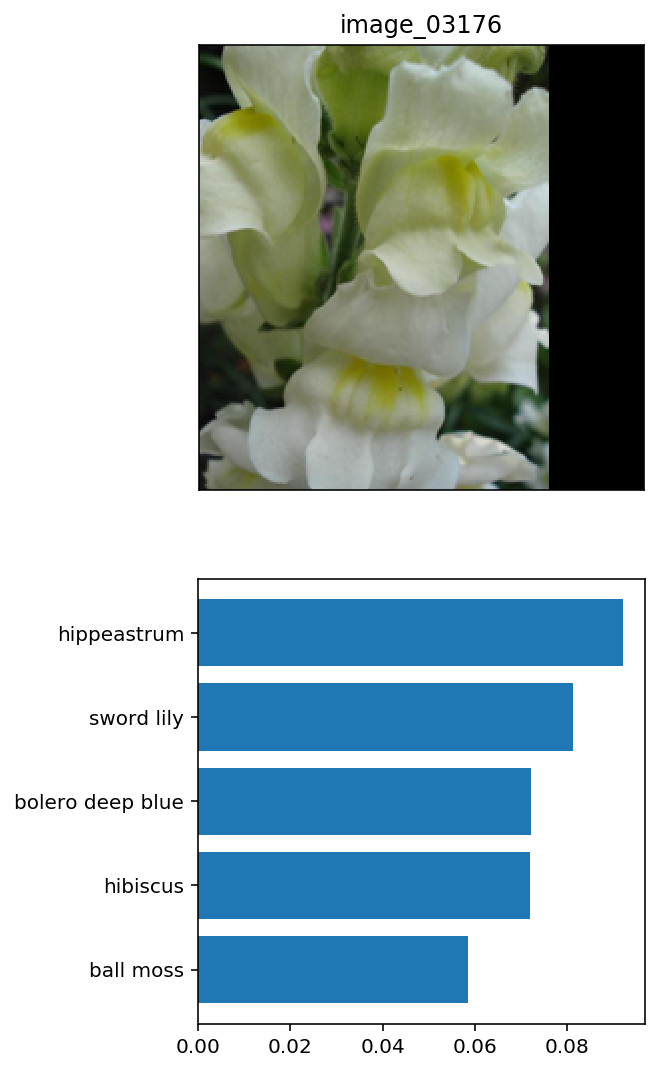

In [89]:
# TODO: Display an image along with the top 5 classes
probs, classes = predict(sample_image_path, loaded_model, 5)
print(probs)
print(classes)

# Open the cat_to_name JSON file
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Get categories from classes
categories = []
for i in range(len(classes)):
    categories.append(cat_to_name[classes[i]])
print(categories)

# Create data dict and data frame for testing purposes
items = {'Top 5 results' : pd.Series(probs),
         'Names' : pd.Series(categories)}
df = pd.DataFrame(items)
print(df)

# Create plot with two images
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches((4, 9))

# Print sample image on top
#plt.subplot(2, 1, 1)
image = Image.open(sample_image_path)
# Get filename as title
image_title = os.path.splitext(os.path.split(sample_image_path)[-1])[0]
processed_image = process_image(image)
imshow(processed_image, ax1, image_title)

# Now hide the labels of the top image, see here:
# https://stackoverflow.com/questions/4079795/hiding-axis-labels
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

# Print probabilities on bottom
ax2 = plt.barh(range(len(probs)), probs)
plt.yticks(range(len(probs)), categories)
# I got the idea to sort y-axis from largest on top to smallest on bottom from here: 
# https://stackoverflow.com/questions/34076177/matplotlib-horizontal-bar-chart-barh-is-upside-down
plt.gca().invert_yaxis()